# Challenge 

The Boston Marathon is one of the most prestigious and history-filled foot races in the world. In this notebook, we will use a [Boston Marathon](https://github.com/llimllib/bostonmarathon) 2014 dataset that has been compiled in a Github repository. For this challenge, we will use several clustering algorithms to see which works best in grouping similar runners together.


In [1]:
# Libraries 
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Clean data
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

# Kmeans
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Metric
import itertools
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist

# Other clustering approaches
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering

# Data Cleaning and Formatting
## Load in the Data and Examine
First, we will load in the data set and format the column names by stripping spaces and convert to lowercase.

In [2]:
# Load in data
url = 'https://raw.githubusercontent.com/llimllib/bostonmarathon/master/results/2014/results.csv'
raw_data = pd.read_csv(filepath_or_buffer=url, header=0)

# Format column names 
raw_data.colummns = raw_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

print(raw_data.shape)

raw_data.head()

(31984, 21)


/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,...,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,...,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.10
2,16.62,"Van Dyk, Ernst F.",1,45.80,M,41,80.60,W2,1,NaN,...,1,3.08,NaN,56.45,7.75,38.03,36.10,RSA,Paarl,76.10
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,...,27,5.37,NaN,99.33,16.20,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,...,2,3.10,NaN,57.03,8.02,38.60,36.58,JPN,Nogata Fukuoka,76.72


In [3]:
# Data types 
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


There are 21 attributes and 31,984 rows in this dataset. Currently, there are 15 categorical and 6 continous varibles describing aspects of runners in the 2014 Boston marathon. We'll convert marathon numbers to integers.



In [4]:
# Convert the marathon numbers to floats.
cols = ['25k', 'half', '30k','10k', '20k', '35k', '40k', '5k']

df = raw_data.copy()

df[cols] = raw_data[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [5]:
# Replace '-' with NaN
df = df.replace('-',np.NaN)

Next, let's take a look at some descriptive statistics. 

In [6]:
# Statistics 
df.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31934.000000,31984.000000,31768.000000,31984.000000,31984.000000,31984.000000,31950.000000,31984.000000,31984.000000,31944.000000,31932.000000,31912.000000,31933.000000,31945.000000
mean,51.799275,1932.563032,133.612055,42.407079,242.997314,8051.044741,196.857605,15939.587825,9.275658,164.571219,25.755559,111.664566,105.711669,229.001490
std,8.965513,1715.228694,25.596958,11.316496,52.300431,4754.005626,41.979107,9232.978224,1.992486,33.953683,4.327830,21.061188,19.780525,49.159902
min,16.620000,1.000000,45.800000,18.000000,80.600000,1.000000,67.420000,1.000000,3.080000,56.450000,7.750000,38.030000,36.100000,76.100000
25%,45.400000,610.000000,115.470000,33.000000,205.527500,3972.000000,167.122500,7943.750000,7.850000,140.670000,22.650000,96.845000,91.750000,193.820000
50%,50.330000,1425.000000,128.875000,42.000000,232.370000,7970.000000,188.170000,15939.500000,8.870000,157.730000,25.080000,107.830000,102.150000,218.850000
75%,57.170000,2611.000000,147.735000,50.000000,273.235000,11968.000000,220.170000,23935.250000,10.430000,182.880000,28.470000,123.070000,116.520000,257.450000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


In [7]:
df.describe(include=['object'])

,name,gender,bib,ctz,state,country,city
count,31984,31984,31984,1244,29408,31984,31983
unique,31915,2,31984,84,68,78,5934
top,"Williams, Doug",M,29065,GBR,MA,USA,Boston
freq,2,17617,1,171,7587,27233,1034


__Observations__:
 * The average of runners is 42
 * Most runners are from Boston, MA given that the is the hosting city
 

## Missing Values
In this section, let's take a look at missing data. Questions that we should keep in mind include how prevalent is missing data and if these values are missing at random. Answering these questions will help us detect potential bias in data collection and uncover truths.

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(df)

Your selected dataframe has 21 columns.
There are 11 columns that have missing values.


,Missing Values,% of Total Values
ctz,30740,96.1
state,2576,8.1
25k,216,0.7
half,72,0.2
5k,52,0.2
20k,51,0.2
10k,50,0.2
30k,40,0.1
40k,39,0.1
35k,34,0.1


Since clustering algorithms do not handle categorical variables well, we will drop the categorical variables with more than two unique values. 

In [10]:
# Drop all categorical columns with 2+ unique values

df2 = df.select_dtypes([np.number])

df2['gender'] = raw_data['gender']

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 15 columns):
10k          31934 non-null float64
division     31984 non-null int64
25k          31768 non-null float64
age          31984 non-null int64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31950 non-null float64
overall      31984 non-null int64
pace         31984 non-null float64
30k          31944 non-null float64
5k           31932 non-null float64
half         31912 non-null float64
20k          31933 non-null float64
40k          31945 non-null float64
gender       31984 non-null object
dtypes: float64(10), int64(4), object(1)
memory usage: 3.7+ MB


In [12]:
# Convert gender to binary classifer 
df2['gender'] = df.gender.map(lambda x: 0 if x is 'F' else 1)

/Users/tsawaengsri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
X = df2.copy()

In [14]:
# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')

# Fit data
imputer.fit(X)

# Transform data
X = imputer.transform(X)

In [15]:
print('Missing values in dataset: ', np.sum(np.isnan(X)))

Missing values in dataset:  0


In [16]:
# Make sure all values are finite
print(np.where(~np.isfinite(X)))

(array([], dtype=int64), array([], dtype=int64))


## PCA 
We'll create a 2-feature PCA for graphing.

In [17]:
# Normalize
Xn = normalize(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(Xn)

Next, we'll separate the data into four equal sets for cross validation.

In [18]:
# Divide into two sets.
Xhalf1, Xhalf2, X_pca_1, X_pca_2 = train_test_split(Xn, X_pca, test_size=0.5, random_state=42)

# Dividing into four sets
X1, X2, X_pca1, X_pca2 = train_test_split(Xhalf1, X_pca_1, test_size=0.5, random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(Xhalf2, X_pca_1, test_size=0.5, random_state=42)

# Checking the length of each set
print(len(X1), len(X_pca1))
print(len(X2), len(X_pca2))
print(len(X3), len(X_pca3))
print(len(X4), len(X_pca4))

7996 7996
7996 7996
7996 7996
7996 7996


In [19]:
# Ensuring all sets are the same length
X2 = X2[:7996][:]
X4 = X4[:7996][:]

X_pca2 = X_pca2[:7996][:]
X_pca4 = X_pca4[:7996][:]

print(len(X2), len(X_pca2))
print(len(X4), len(X_pca4))

7996 7996
7996 7996


# Exploring Clusters

## K Means Modeling
We create two data frames, one for the y predictions from a kmeans model, and another silhouette scores for the different clusters. Later we fit the model for 2 to 5 clusters, calculating silhouette scores for each.


In [20]:
# Initialize data frames
ypred = pd.DataFrame()
score = pd.DataFrame(columns=['cluster_pred','sil_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
       
        # Instantiating and fit_predicting model to then add to data frame
        kmeans = KMeans(n_clusters=nclust, random_state=42)
        pred = kmeans.fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = kmeans.labels_
        sscore = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score = score.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore}, ignore_index=True)

In [21]:
# Sorting sihoilette scores
score.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,sil_score,silhouette_score
6,clust4_sample1,NaN,0.495658
2,clust4_sample0,NaN,0.493524
10,clust4_sample2,NaN,0.493257
14,clust4_sample3,NaN,0.491322
5,clust3_sample1,NaN,0.478796
13,clust3_sample3,NaN,0.476207
9,clust3_sample2,NaN,0.476144
1,clust3_sample0,NaN,0.474392
0,clust2_sample0,NaN,0.459806
7,clust5_sample1,NaN,0.457907


A four-cluster system has the highest silhouette scores.

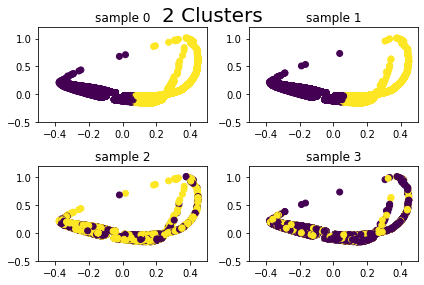

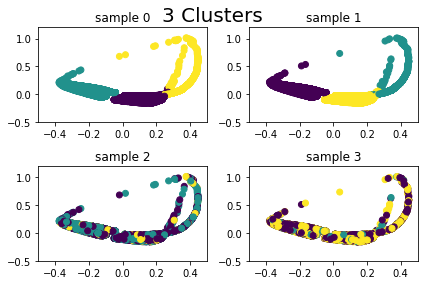

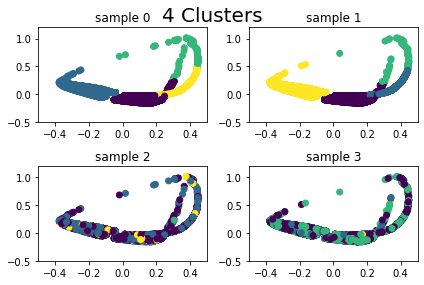

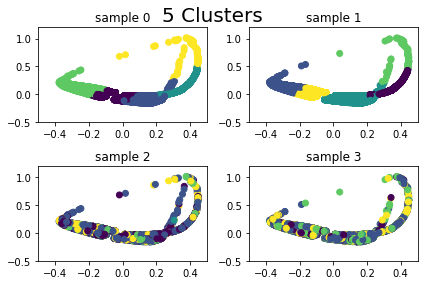

In [22]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Watching the latter plots of the 2-feature PCA data, the 4-cluster solution is consistent across samples 0 and 1, but inconsistent across samples 2 and 3.

## Mean-shift
For a mean-shift model, we will use a range of quantiles to create bandwidths from 0.1 to 0.4, calculating the Silhouette scores for each.

In [23]:
# Initialize new data frames
ypred_ms = pd.DataFrame()
score_ms = pd.DataFrame(columns=['cluster_pred','mean_shift', 'quantile'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Creating a list of possible quantiles to test in mean shift.
    for n in [0.1, 0.2, 0.3, 0.4]:
        # Estimating number of clusters for data
        bandwidth = estimate_bandwidth(data, quantile=n, n_samples=500)
        # Ensuring all sets are the same lenght
        data = data[:4013][:]
        # Instantiating and fit_predicting model to then add to data frame
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        pred = ms.fit_predict(data)
        labels = ms.labels_
        cntrs = len(np.unique(labels))
        ypred_ms['clust' + str(cntrs) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        sscore = metrics.silhouette_score(data, labels, metric='euclidean')
        score_ms = score_ms.append({'cluster_pred':'clust' + str(cntrs) + '_sample' + str(counter), 
                              'silhouette_score':sscore, 'quantile':n}, ignore_index=True)

In [24]:
score_ms.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,mean_shift,quantile,silhouette_score
6,clust2_sample1,NaN,0.3,0.548806
13,clust3_sample3,NaN,0.2,0.524161
7,clust4_sample1,NaN,0.4,0.514275
5,clust4_sample1,NaN,0.2,0.514219
1,clust4_sample0,NaN,0.2,0.509803
3,clust5_sample0,NaN,0.4,0.501404
2,clust5_sample0,NaN,0.3,0.497197
14,clust4_sample3,NaN,0.3,0.490220
0,clust9_sample0,NaN,0.1,0.486770
8,clust9_sample2,NaN,0.1,0.483634


The quantile of 0.3 calculated a high Silhouette score for sample 1 and generated 2 clusters.

## Spectral Clustering
For the spectral clustering model, we use a range of clusters from 2 to 5, and we calculate the corresponding Silhouette scores for each.

In [25]:
# Initialize data frames
ypred_sc = pd.DataFrame()
score_sc = pd.DataFrame(columns=['cluster_pred','silhouette_score'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred_sc['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred_sc['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Creating a list of possible number of clusters to test in kmeans.
    for nclust in range(2, 6):
        # Instantiating and fit_predicting model to then add to data frame
        sc = SpectralClustering(n_clusters=nclust)
        pred = sc.fit_predict(data[0])
        ypred_sc['clust' + str(nclust) + '_sample' + str(counter)] = pred
        # Calculating silhouette scores for the data and adding that to the shilouette score
        labels = sc.labels_
        sscore_sc = metrics.silhouette_score(data[0], labels, metric='euclidean')
        score_sc = score_sc.append({'cluster_pred':'clust' + str(nclust) + '_sample' + str(counter), 
                              'silhouette_score':sscore_sc}, ignore_index=True)

In [26]:
score_sc.sort_values(by='silhouette_score', ascending=False)

,cluster_pred,silhouette_score
7,clust5_sample1,0.494479
3,clust5_sample0,0.492925
11,clust5_sample2,0.491279
15,clust5_sample3,0.489840
6,clust4_sample1,0.488724
2,clust4_sample0,0.487568
10,clust4_sample2,0.487134
14,clust4_sample3,0.486411
0,clust2_sample0,0.464299
8,clust2_sample2,0.462665


A 4 cluster configuration generates the highest silhouette score.

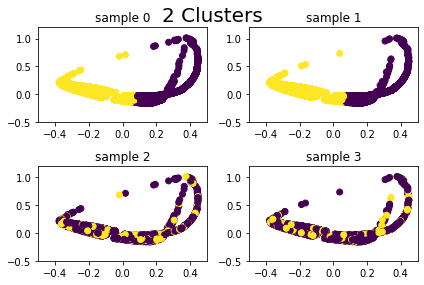

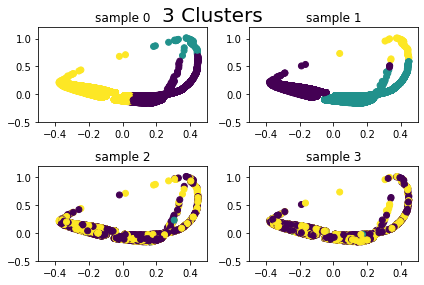

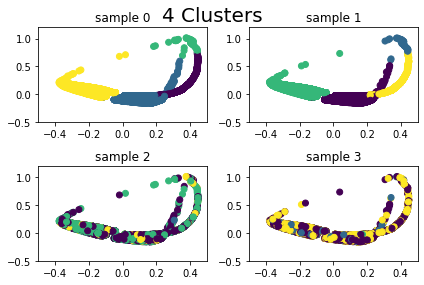

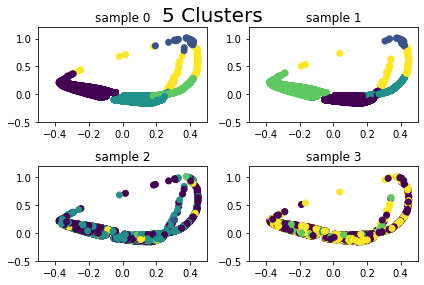

In [27]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 6):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = ypred_sc['pca_f1_sample{}'.format(i)]
        y_sub = ypred_sc['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred_sc['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.5, .5])
        axarr[rows, cols].set_ylim([-.5, 1.2])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Watching the latter plots of the 2-feature PCA data, the 2 and 3 cluster configuration show a consistent solution across samples 0 and 1, but inconsistent across samples 2 and 3. The 4 and 5 cluster configuration show overfitting for all samples.

## Affinity Propagation
For the Affinity Propagation model, we allow the model to find the k number of cluster, and later we calculate the corresponding Silhouette scores for each.

In [28]:
# Initialize data frames
ypred = pd.DataFrame()
score_af = pd.DataFrame(columns=['cluster_pred','AF'])

# Keep track of counts of the models and use data from the different folds
for counter, data in enumerate([X1, X2, X3, X4]):
    # Ensuring all sets are the same lenght
    data = data[:4013][:]
    # Instantiating and fit_predicting model to then add to data frame
    af = AffinityPropagation().fit(data)
    cluster_centers_indices = af.cluster_centers_indices_
    n_clusters_ = len(cluster_centers_indices)
    #pred = af.fit_predict(data)
    #ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred
    # Calculating silhouette scores for the data and adding that to the shilouette score
    labels = af.labels_
    sscore_af = metrics.silhouette_score(data, labels, metric='euclidean')
    score_af = score_af.append({'cluster_pred':'clust' + str(n_clusters_) + '_sample' + str(counter), 
                              'AF':sscore_af}, ignore_index=True)

In [29]:
score_af.sort_values(by='AF', ascending=False)

,cluster_pred,AF
3,clust1287_sample3,0.206786
1,clust1807_sample1,0.192890
2,clust2926_sample2,0.082612
0,clust2861_sample0,0.077947


The AF scores are low, suggesting not to be reliable.

# Conclusion
Overall, mean shift did the best with 54% accuracy. The top result needed around two or three clusters which suggests two or three main group of runners in the marathon. I will now see what the main groups were in the K Means model.

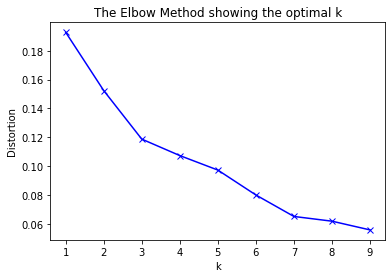

In [30]:
# Use the elbow method to see what is the optimal amount of clusters.

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X1)
    kmeanModel.fit(X1)
    distortions.append(sum(np.min(cdist(X1, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X1.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

3 clusters are the optimal amount of clusters because we see that if a 4th cluster is added, the SSE or distortion will only drop .02 which isn't as good. Although the elbow is more at 2 clusters, there is still a significant drop of .06 so 3 clusters is the optimal amount of clusters to lower the sum of squared errors.

In [34]:
cluster_pred = KMeans(n_clusters=3, random_state=42).fit_predict(X)
X_pred = df2.copy()
X_pred['cluster_assignment'] = cluster_pred

cluster_dataframes = {}
for n_clust in range(3):
    cluster_dataframes[n_clust] = X_pred.loc[X_pred['cluster_assignment'] == n_clust]

for name, frame in cluster_dataframes.items():
    print(name)
    print('\n')
    print(frame.describe())

0


                10k      division           25k           age      official  \
count  10565.000000  10590.000000  10393.000000  10590.000000  10590.000000   
mean      61.382338   3063.758735    162.365201     44.042493    303.786279   
std        7.023046   2068.272012     19.902858     12.832617     37.977564   
min       38.470000      1.000000     70.000000     18.000000    251.220000   
25%       56.570000   1426.250000    147.880000     33.000000    273.600000   
50%       60.600000   2290.000000    158.600000     44.000000    294.350000   
75%       65.250000   5121.750000    173.900000     54.000000    326.460000   
max      112.380000   6979.000000    289.020000     81.000000    538.880000   

          genderdiv           35k       overall          pace           30k  \
count  10590.000000  10572.000000  10590.000000  10590.000000  10566.000000   
mean   13345.621719    245.019867  26607.132106     11.592874    202.844415   
std     2187.154135     32.110176   3107.917484

## Cluster Analysis
Cluster 0

Half of them are guys.
On average they run at a 8 minute pace.
The average age is 41, but the standard deviation in age is 10 years.
The average placing of the group in their competitions is around 8600.
Cluster 1

The majority of the runners are females, holding 61%.
They run at an 8.91 minute pace, which is slightly slwoer than the previous cluster.
This cluster has a more diverse age range where the average age is 46, but the standard deviation is also 10 years.
On average, this group will place around 14,500.
Cluster 2

This cluster are 86% male.
This a faster cluster since their pace is 6.97.
This cluster is also younger, the average age being 37 and the standard deviation in age is 8 years.
Unsurprisingly, this cluster also places higher with the average rank being around 2800.

In [35]:
# run k-means on the full dataset
n_clusters = 3
km_model = KMeans(n_clusters = n_clusters, random_state = 42)
km_model.fit(X_pred)
# add labels to data for analysis
X_label = X_pred.copy()
X_label['label'] = km_model.labels_

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
# look at age histograms by cluster
fig,ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green'}
grouped = X_label.groupby('label')
for key,group in grouped:
    group['age'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha = 0.6)
plt.legend()
plt.xlabel('Age')
plt.title('Age Distributions by Cluster')
plt.show()

Here we can see that the youngest people are in cluster 2 but the majority of the age range of the clusters still overlap.

In [ ]:
# look at pace histograms by cluster
fig,ax = plt.subplots()
for key,group in grouped:
    group['pace'].plot(ax=ax, kind='hist', label=key, color=colors[key], alpha = 0.7)
plt.legend()
plt.xlabel('Pace')
plt.title('Official Distributions by Cluster')
plt.show()

Here we can see that cluster 2 is the fastest with there being a few outliers that can run at a 4 or 5 minute pace. Group 1 is the slowest but that is reasonable due to the fact that they are also the slowest.

In [ ]:
# Calculate predicted values.
y_pred = KMeans(n_clusters=4, random_state=42).fit_predict(Xn)

In [ ]:
df_y = pd.DataFrame(y_pred)
df_y.columns = ['Cluster']

In [ ]:
# Add the outcome back onto X
combined = df.join(df_y, how='inner')
combined.head()

In [ ]:
# Create age buckets

def age_bucket(age):
    output = ''
    if age <=20:
        output = 'Under 20'
    elif (age > 20 and age <= 30):
        output = 'Between 20 and 30'
    elif (age > 30 and age <= 40):
        output = 'Between 30 and 40'
    elif (age > 40 and age <= 50):
        output = 'Between 40 and 50'
    elif (age > 50 and age <= 60):
        output = 'Between 50 and 60'
    else:
        output = 'Over 60'
    
    return output

In [ ]:
combined['Age Bucket'] = combined['age'].apply(lambda x: age_bucket(x))

In [ ]:
# Official time between the groups
plt.figure(figsize=(16,8))
sns.boxplot(x='Cluster',y='official',data=combined)

From the plot above, we can see how our algorithm divided the clusters in maximium, intermediate and minumum official time records. We can also observe a number of outliers for each cluster.

In [ ]:
# Look at Gender Breakdown for Count
g = sns.factorplot(x='Age Bucket', col='Cluster', kind="count", data=combined, size=4)
g.set_xticklabels(rotation=90)

From the plot above, we can see that it seems that, for example, that the cluster with best records (less time), cluster 3, has a slightly higher number of runners with an age between 20 and 30, over the rest of the runners.

In [ ]:
sns.factorplot(x='gender', col='Cluster', kind="count", data=combined, size=5)

Considering 0 = Female, 1 = Male, we can observe that in cluster 3 (best records), there is a predominant number of male runners. We confirm with following count values:

In [ ]:
# Separate the clusters
cluster0 = combined[combined['Cluster']==0]
cluster1 = combined[combined['Cluster']==1]
cluster2 = combined[combined['Cluster']==2]
cluster3 = combined[combined['Cluster']==3]

In [ ]:
# check Gender Breakdown
cluster0['gender'].value_counts()

In [ ]:
cluster1['gender'].value_counts()

In [ ]:
cluster2['gender'].value_counts()

In [ ]:
cluster3['gender'].value_counts()

We can point out that our algorithm, did a great job in grouping the different runners according to their time records, and after analyzing the results, they reflect a feasible outcome.